# Exploração dos dados da tabela
Neste processo vamos explorar um pouco os dados baixados para ver o que é necessário fazer de transformações para gerar as próxima
camada. 

Iniciamos importandos as bibliotecas que utilizaremos e configurando o ```spark```.

In [1]:
import pyspark.sql.functions
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from datetime import datetime
from environment import *

In [2]:
spark = (SparkSession.builder
         .appName(f"Teste Spark")
         .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
         .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")         
         .getOrCreate()
)

## Carregar a Delta Table no Spark
Primeiramente carregamos os dados da Delta Table para o Spark e registramos para usar como tabela em comandos SQL.

In [3]:
%%time
df = (spark
      .read
      .format("delta")
      .load(f'lakehouse/bronze/vendas')
)

CPU times: user 1.89 ms, sys: 849 µs, total: 2.74 ms
Wall time: 4.72 s


Registrando como uma tabela de Banco de dados

In [4]:
df.createOrReplaceTempView("vendas")

## Consultando a tabela com o uso de SQL

In [5]:
%%sql_display
select * 
from vendas 
order by InvoiceDate
limit 10;

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


## Identificar Invoices canceladas

Segundo a regra de negócio exposta no notebook NMSYS 101-01, o campo InvoiceNo Pode iniciar com a letra C.
Nestes casos isto indica que esta transação foi cancelada.

Vamos escrever uma query que identifica estes casos para verificarmos quantas operações canceladas existem na base de dados.

In [6]:
%%time
df_tipo = spark.sql("""
select
    "Vendas" as tipo,
    sum(case when left(InvoiceNo, 1) = 'C' then 0 else 1 end) as Qtd
from vendas

union

select
    "Cancelamento" as tipo,
    sum(case when left(InvoiceNo, 1) = 'C' then 1 else 0 end) as Qtd
from vendas
""").toPandas()

CPU times: user 7.5 ms, sys: 0 ns, total: 7.5 ms
Wall time: 1.1 s


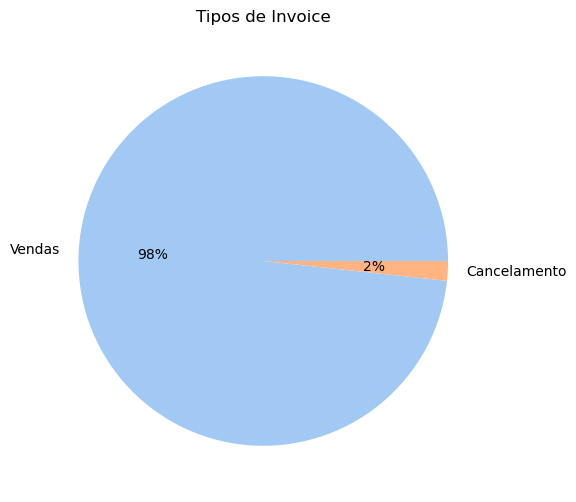

In [7]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(6,6))

#create pie chart
plt.pie(df_tipo["Qtd"], labels = df_tipo["tipo"], colors = colors, autopct='%.0f%%')
plt.title('Tipos de Invoice')
plt.show()

__Conclusão__: No processo acima identificamos como distinguir uma invoice de venda de uma de cancelamento, além de determinar a quantidade de invoices em ambos os casos.